In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

import scipy.signal as signal

In [2]:
plt.style.use('notebook')

In [3]:
t = Table.read('../data/Kepler_10976252.0.txt', format='ascii')

tatlas = Table.read('../data/ATLAS_10976252.csv')
ind = tatlas['sigma1']>0
tatlas = tatlas[ind]

tasassn = Table.read('../data/10976252ASASSN_V.dat', format='ascii.commented_header')

In [14]:
tm_k = t['col1']
flux_k = t['col2']
fnorm_k = flux_k - np.mean(flux_k)
ivar_k = (np.ones_like(flux_k)*0.002)**-1

Nfreq = 10000
# freq = np.logspace(-3,0,Nfreq)
freq = np.linspace(0.001,1,Nfreq)
frlin = (freq / (2*np.pi) * u.day**-1).to(u.uHz)
pgram_k = signal.lombscargle(tm_k, fnorm_k, freq, normalize=True)

In [15]:
tm = tatlas['MJD']
flux = tatlas['mag']
fnorm = flux - np.mean(tatlas['mag'])
ivar = tatlas['sigma1']**-1

pgram = signal.lombscargle(tm, fnorm, freq, normalize=True)

In [16]:
tm_as = tasassn['HJD']
flux_as = tasassn['mag']
fnorm_as = flux_as - np.mean(flux_as)
ivar_as = tasassn['mag_err']**-1

pgram_as = signal.lombscargle(tm_as, fnorm_as, freq, normalize=True)

In [17]:
print(len(t), len(tatlas), len(tasassn))

58735 407 276


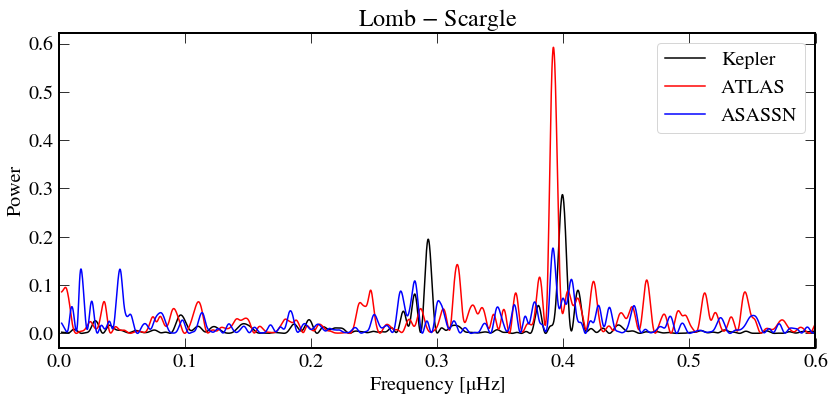

In [18]:
plt.figure(figsize=(12,6))
# plt.plot(freq*1.85, pgram, 'k-')
plt.plot(frlin, pgram_k, 'k-', label='Kepler')
plt.plot(frlin, pgram, 'r-', label='ATLAS')
plt.plot(frlin, pgram_as, 'b-', label='ASASSN')

plt.xlim(0,0.6)
plt.legend(loc=1)
plt.xlabel('Frequency [$\mu$Hz]')
plt.ylabel('Power')
plt.title('Lomb $-$ Scargle')
plt.tight_layout()
plt.savefig('../plots/survey_comparison_LS_{:06d}.png'.format(Nfreq))

## Likelihood

In [19]:
def ln_profile_like_K_freqs(ts, ys, yivars, nu, deltanu, K=3):
  assert len(ts) == len(ys)
  halfK = (K - 1) // 2
  thisK = 2 * halfK + 1
  A = np.zeros((len(ts), 2 * thisK + 1))
  for k in range(thisK):
    f = nu - halfK * deltanu + k * deltanu
    A[:, 2 * k]     = np.cos(2. * np.pi * f * ts)
    A[:, 2 * k + 1] = np.sin(2. * np.pi * f * ts)
  A[:, -1] = 1.
  resid = ys - np.dot(A, np.linalg.solve(np.dot(A.T * yivars, A), np.dot(A.T * yivars, ys)))
  return -0.5 * np.sum(yivars * resid ** 2)

In [20]:
dfreq0 = 0.1
K0 = 2
fll_as = np.array([ln_profile_like_K_freqs(tm_as, fnorm_as, ivar_as, f, dfreq0, K=K0) for f in freq])
fll = np.array([ln_profile_like_K_freqs(tm, fnorm, ivar, f, dfreq0, K=K0) for f in freq])
fll_k = np.array([ln_profile_like_K_freqs(tm_k, fnorm_k, ivar_k, f, dfreq0, K=K0) for f in freq])

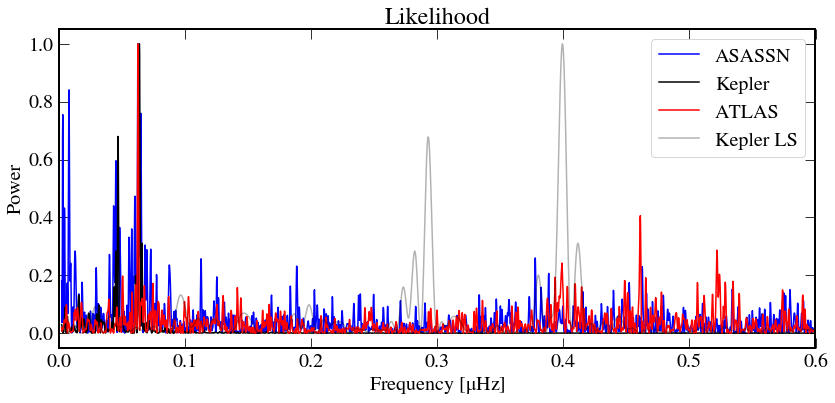

In [21]:
plt.figure(figsize=(12,6))

norm_fll = fll - np.min(fll)
norm_fll = norm_fll / np.max(norm_fll)
norm_fll_as = fll_as - np.min(fll_as)
norm_fll_as = norm_fll_as / np.max(norm_fll_as)
norm_fll_k = fll_k - np.min(fll_k)
norm_fll_k = norm_fll_k / np.max(norm_fll_k)

plt.plot(frlin, norm_fll_as, 'b-', label='ASASSN')
plt.plot(frlin, norm_fll_k, 'k-', label='Kepler')
plt.plot(frlin, norm_fll, 'r-', label='ATLAS')

plt.plot(frlin, pgram_k/np.max(pgram_k), 'k-', alpha=0.3, label='Kepler LS')

# plt.plot(freq, fll - np.mean(fll), 'r-', label='ATLAS')
# plt.plot(freq, fll_as - np.mean(fll_as), 'b-', label='ASASSN')
# plt.plot(freq, fll_k - np.mean(fll_k), 'k-', label='Kepler')

plt.xlim(0,0.6)
plt.legend(loc=1)
plt.xlabel('Frequency [$\mu$Hz]')
plt.ylabel('Power')
plt.title('Likelihood')
plt.tight_layout()
plt.savefig('../plots/survey_comparison_lhood.png')

## 2D likelihood surface

In [100]:
dfreq = np.linspace(0.01,0.1,1000)

In [101]:
# do a two-d likelihood surface
lls = np.zeros((len(dfreq), len(freq)))
for i,f in enumerate(freq):
  for j,df in enumerate(dfreq):
    lls[j, i] = ln_profile_like_K_freqs(tm, flux, ivar, f, df, K=K0)

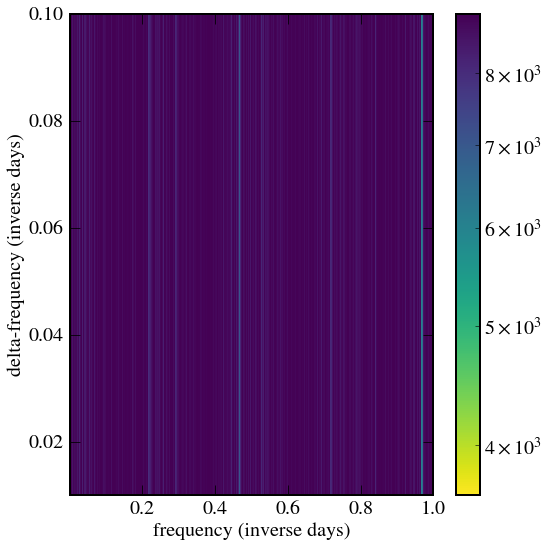

In [117]:
foo = np.median(freq[1:] - freq[:-1])
pfreq = freq - 0.5 * foo
pfreq = np.append(pfreq, pfreq[-1] + foo)
foo = np.median(dfreq[1:] - dfreq[:-1])
pdfreq = dfreq - 0.5 * foo
pdfreq = np.append(pdfreq, pdfreq[-1] + foo)

# plt.pcolormesh(pfreq, pdfreq, np.abs(lls), norm=mpl.colors.LogNorm(), cmap='viridis_r')

plt.imshow(np.abs(lls), extent=[freq[0], freq[-1], dfreq[0], dfreq[-1]], aspect='auto',
           norm=mpl.colors.LogNorm(), cmap='viridis_r')

# plt.xlim(freq[0], freq[-1])
# plt.ylim(dfreq[0], dfreq[-1])
plt.xlabel('frequency (inverse days)')
plt.ylabel('delta-frequency (inverse days)')
plt.colorbar()

plt.tight_layout()